# Prototyping Qick board software

The following is the test notebook I have used to develop the qick_sweep class. The first measurement is simply a normal qick sweep that uses the config class. To that it follows a test with a measurement with a single sweep, then a measurement with 2 sweeps.

Some basic documentation on how to use the qick board:



### Imports

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import numpy as np
from qick import *
from qick.averager_program import QickSweep
from tqdm.notebook import tqdm

from labcore.instruments.qick.config import QBoardConfig
from instrumentserver.client.proxy import Client

import qick_sweep
from qick_sweep import QickBoardSweep

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
cli = Client()
params = cli.find_or_create_instrument("parameter_manager")

In [3]:
class QickConfig(QBoardConfig):
    def config_(self):
        params = self.params
        cfg = {
            # Define the channels that you are going to be using
            "qubit_ch": 1,  # Generating signals through channel 0
            "read_gen_ch": 0, # Generating signals through channel 0

            "read_ch": 0,  # Reading signals through channel 0
            
            # Configuring the qubit
            "qubit_gain": params.qubit.gain(),
            "qubit_length": params.qubit.len(),
            "qubit_freq": params.qubit.freq(),
            "qubit_sigma": self.soccfg.us2cycles(params.qubit.sigma(), gen_ch=0),
            
            # Configuring Readout
            "readout_length": self.soccfg.us2cycles(params.readout.length(), gen_ch=0),
            "readout_phase": params.readout.phase(),
            "readout_freq": params.readout.freq(),
            "adc_trig_offset": params.adc_trig_offset(), # [Clock Ticks]
            "readout_gain": params.readout.gain(),
            "relax_delay": self.soccfg.us2cycles(params.readout.relax_delay()),

            # Configuration of the measurement
            "expts": params.measurement.expts(),
            "start": params.measurement.start(),
            "stop": params.measurement.stop(),
            "step": params.measurement.step(),
            "phase_start": params.measurement.phase_start(),
            "phase_stop": params.measurement.phase_stop(),
            "phase_step": params.measurement.phase_step(),
            "phase_expts": params.measurement.phase_expts(),
        }

        return cfg


In [4]:
class SingleToneSpectroscopyProgram(NDAveragerProgram):

    def initialize(self):
        cfg=self.cfg
        self.declare_gen(ch=cfg["read_gen_ch"], nqz=1, ro_ch=cfg["read_ch"]) # Readout
        self.declare_readout(ch=cfg["read_ch"], length=cfg["readout_length"],
                                freq=cfg["start"], gen_ch=cfg["read_gen_ch"])

        freq = self.freq2reg(cfg["start"], gen_ch=cfg["read_gen_ch"], ro_ch=cfg["read_ch"])
        self.set_pulse_registers(ch=cfg["read_gen_ch"], style="const", freq=freq, phase=0, gain=cfg["readout_gain"], length=cfg["readout_length"])
        
        self.gen_r_freq = self.get_gen_reg(cfg["read_gen_ch"], "freq")
        self.add_sweep(QickSweep(self, self.gen_r_freq, cfg["start"], cfg["stop"], cfg["expts"]))

        self.synci(200) # give processor some time to configure pulses

    def body(self):

        cfg = self.cfg

        self.sync_all(self.us2cycles(1))

        self.measure(adcs=self.ro_chs,
                     pulse_ch=cfg["read_gen_ch"],
                    #  pins=[0],
                     adc_trig_offset=0,
                     wait=True,
                     syncdelay=self.us2cycles(cfg["readout_length"]),
                     )
        

In [5]:
conf = QickConfig(params=params)
rspec = SingleToneSpectroscopyProgram(*conf.config())
res = rspec.acquire(conf.soc ,progress=True)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [6]:
print(res)
[np.shape(i) for i in res]

([array([30., 40., 50.])], [array([[-0.00298534,  0.00220033, -0.00037296]])], [array([[ 0.00161238,  0.00176547, -0.00243811]])])


[(1, 3), (1, 1, 3), (1, 1, 3)]

# Starting prototyping of sweep

## Single sweep

In [69]:
from labcore.measurement import independent, dependent
from labcore import setup_measurements
setup_measurements.DATADIR = "./data"
setup_measurements.options.instrument_clients = {'instruments': cli}
setup_measurements.options.parameters = params



In [70]:
@QickBoardSweep(
    independent("sweep_axis"),
    dependent("i", depends_on=["sweep_axis"]),
    dependent("q", depends_on=["sweep_axis"])
)
class SingleToneSpectroscopySweepProgram(NDAveragerProgram):

    def initialize(self):
        cfg=self.cfg

        self.declare_gen(ch=cfg["read_gen_ch"], nqz=1, ro_ch=cfg["read_ch"]) # Readout
        
        self.declare_readout(ch=cfg["read_ch"], length=cfg["readout_length"],
                                freq=cfg["start"], gen_ch=cfg["read_gen_ch"])

        freq = self.freq2reg(cfg["start"], gen_ch=cfg["read_gen_ch"], ro_ch=cfg["read_ch"])
        self.set_pulse_registers(ch=cfg["read_gen_ch"], style="const", freq=freq, phase=0, gain=cfg["readout_gain"], length=cfg["readout_length"])
        
        self.gen_r_freq = self.get_gen_reg(cfg["read_gen_ch"], "freq")

        self.add_sweep(QickSweep(self, self.gen_r_freq, cfg["start"], cfg["stop"], cfg["expts"]))

        self.synci(200) # give processor some time to configure pulses

    def body(self):

        cfg = self.cfg

        self.sync_all(self.us2cycles(1))

        self.measure(adcs=self.ro_chs,
                     pulse_ch=cfg["read_gen_ch"],
                    #  pins=[0],
                     adc_trig_offset=0,
                     wait=True,
                     syncdelay=self.us2cycles(cfg["readout_length"]),
                     )
        

I am in the init


In [71]:
conf = QickConfig(params=params)
qick_sweep.config = conf
sweep = SingleToneSpectroscopySweepProgram()

In [72]:
setup_measurements.run_measurement(sweep, "Testing_qick")

# print("here I go")
# things = []
# for i in sweep:
#     things.append(i)

[2024-04-18 21:09:50.148] [labcore.utils.misc: WARNING] The package qick has uncommitted changes. Will not be tracked. Please fix
[2024-04-18 21:09:50.159] [labcore.utils.misc: WARNING] The package instrumentserver has uncommitted changes. Will not be tracked. Please fix
[2024-04-18 21:09:50.160] [root: WARNING] The current directory is not a git repository, your measurement code will not be tracked.
[2024-04-18 21:09:50.162] [labcore.data.datadict_storage: INFO] Data location: data/2024-04-18/2024-04-18T210950_e71f8a34-Testing_qick/data.ddh5
[2024-04-18 21:09:50.179] [labcore.instruments.qick.config: INFO] Generated soccfg
[2024-04-18 21:09:50.179] [labcore.instruments.qick.config: INFO] 
QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.249
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=61

(PosixPath('data/2024-04-18/2024-04-18T210950_e71f8a34-Testing_qick'), None)

## Multiple sweeps

In [73]:
@QickBoardSweep(
    independent("sweep_axis"),
    dependent("i", depends_on=["sweep_axis"]),
    dependent("q", depends_on=["sweep_axis"])
)
class SingleToneSpectroscopySweepProgram(NDAveragerProgram):

    def initialize(self):
        cfg=self.cfg

        self.declare_gen(ch=cfg["read_gen_ch"], nqz=1, ro_ch=cfg["read_ch"]) # Readout
        
        self.declare_readout(ch=cfg["read_ch"], length=cfg["readout_length"],
                                freq=cfg["start"], gen_ch=cfg["read_gen_ch"])

        freq = self.freq2reg(cfg["start"], gen_ch=cfg["read_gen_ch"], ro_ch=cfg["read_ch"])
        phase = self.deg2reg(cfg["start"], gen_ch=cfg["read_gen_ch"])
        self.set_pulse_registers(ch=cfg["read_gen_ch"], style="const", freq=freq, phase=phase, gain=cfg["readout_gain"], length=cfg["readout_length"])
        
        self.gen_r_freq = self.get_gen_reg(cfg["read_gen_ch"], "freq")
        self.gen_r_phase = self.get_gen_reg(cfg["read_gen_ch"], "phase")

        self.add_sweep(QickSweep(self, self.gen_r_freq, cfg["start"], cfg["stop"], cfg["expts"]))
        self.add_sweep(QickSweep(self, self.gen_r_phase, cfg["phase_start"], cfg["phase_stop"], cfg["phase_expts"]))

        self.synci(200) # give processor some time to configure pulses

    def body(self):

        cfg = self.cfg

        self.sync_all(self.us2cycles(1))

        self.measure(adcs=self.ro_chs,
                     pulse_ch=cfg["read_gen_ch"],
                    #  pins=[0],
                     adc_trig_offset=0,
                     wait=True,
                     syncdelay=self.us2cycles(cfg["readout_length"]),
                     )

I am in the init


In [74]:
conf = QickConfig(params=params)
qick_sweep.config = conf
sweep = SingleToneSpectroscopySweepProgram()

In [76]:
# setup_measurements.run_measurement(sweep, "Testing_qick")
print("here I go")
things = []
for i in sweep:
    things.append(i)

here I go
Inside of data:
([array([1.  , 2.25, 3.5 , 4.75, 6.  ]), array([20., 22.])],
 [array([[[ 0.00281922,  0.00506189, -0.00271987,  0.00182899,
         -0.00989902],
        [ 0.00319055,  0.00075733,  0.00360261,  0.00340554,
          0.00267101]]])],
 [array([[[-0.00284853,  0.0011987 ,  0.0042329 ,  0.00860098,
         -0.00236645],
        [ 0.00802932, -0.0006645 , -0.00618893,  0.004     ,
          0.00442834]]])])


In [46]:
things

[{'sweep_axis': None, 'i': None, 'q': None},
 {'sweep_axis': array([1.  , 2.25, 3.5 , 4.75, 6.  ]),
  'i': array([[[-0.00028827,  0.00365798, -0.0032899 , -0.00058469,
            0.00663844],
          [ 0.00091531,  0.00485993,  0.00390065,  0.00444951,
            0.0095114 ]]]),
  'q': array([[[-0.00557166,  0.00813029, -0.00567264,  0.00736156,
           -0.00229479],
          [ 0.00439739, -0.00038111,  0.00431433, -0.00260261,
            0.00062378]]])}]

# ----- end of prototypying -------

In [ ]:
fpts = res[0][0]
amps = res[1][0][0] + 1j*res[2][0][0]
print(np.shape(amps))

In [ ]:
plt.subplot(111,title="Resonator Spectroscopy", xlabel="Resonator Frequency (MHz)", ylabel="Amp. (adc level)")
plt.plot(fpts, np.abs(amps),'o-')
max_freq=fpts[np.argmax(amps)]
plt.show()

# Resonator spec spectroscopy

In [45]:
class SingleToneSpectroscopyProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        self.declare_gen(ch=cfg["gen_ch"], nqz=1) #Readout
         #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["read_ch"], length=cfg["readout_length"], freq=cfg["readout_freq"], gen_ch=cfg["gen_ch"])
        
        freq=self.freq2reg(cfg["readout_freq"], gen_ch=cfg["gen_ch"], ro_ch=0)  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.set_pulse_registers(ch=cfg["gen_ch"], style="const", freq=freq, phase=0, gain=cfg["readout_gain"], length=cfg["readout_length"])

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.measure(pulse_ch=self.cfg["gen_ch"], 
             adcs=[0],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))        

  0%|          | 0/400 [00:00<?, ?it/s]

Generating soccfg


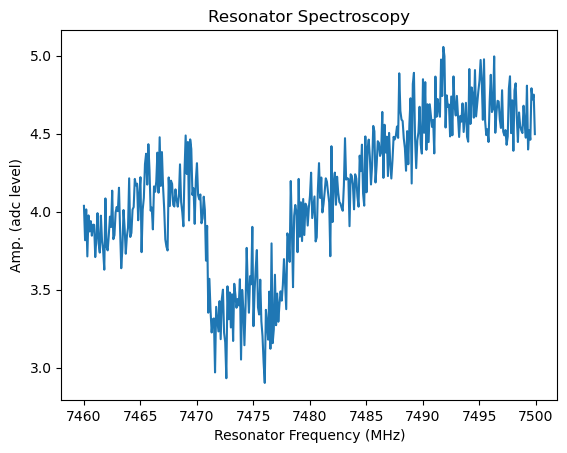

In [65]:
conf = QickConfig(params=params)
fpts=params.measurement.start() + params.measurement.steps()*np.arange(params.measurement.expts())

amps=[]
for f in tqdm(fpts):
    params.readout.freq(f)

    rspec=SingleToneSpectroscopyProgram(*conf.config())
    avgi,avgq=rspec.acquire(conf.soc)
    amp=np.abs(avgi[0][0]+1j*avgq[0][0])
    amps.append(amp)
amps=np.array(amps)

plt.subplot(111,title="Resonator Spectroscopy", xlabel="Resonator Frequency (MHz)", ylabel="Amp. (adc level)")
plt.plot(fpts, amps)
max_freq=fpts[np.argmax(amps)]
plt.show()

## High power

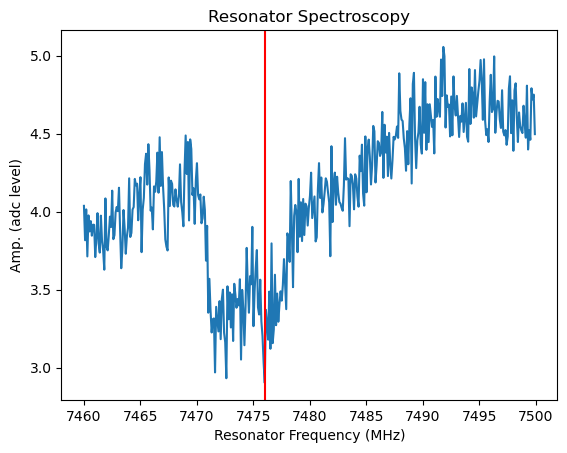

In [67]:

plt.subplot(111,title="Resonator Spectroscopy", xlabel="Resonator Frequency (MHz)", ylabel="Amp. (adc level)")
plt.plot(fpts, amps3)
max_freq=fpts[np.argmin(amps3)]
axvline(max_freq, color='r')
plt.show()

# Low power

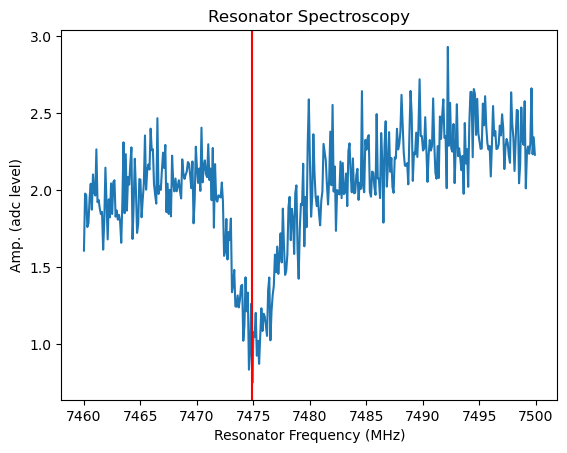

In [64]:

plt.subplot(111,title="Resonator Spectroscopy", xlabel="Resonator Frequency (MHz)", ylabel="Amp. (adc level)")
plt.plot(fpts, amps2)
max_freq=fpts[np.argmin(amps2)]
plt.axvline(max_freq, color="r")
plt.show()

# Qubit Pulse spectroscopy

In [87]:
class PulseProbeSpectroscopyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.declare_gen(ch=cfg["read_gen_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        
        self.declare_readout(ch=cfg["read_ch"], length=cfg["readout_length"],
                                freq=cfg["readout_freq"], gen_ch=cfg["read_gen_ch"])

        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_freq=self.sreg(cfg["qubit_ch"], "freq")   # get frequency register for qubit_ch    
        
        f_res=self.freq2reg(cfg["readout_freq"], gen_ch=cfg["read_gen_ch"], ro_ch=0) # conver f_res to dac register value

        self.f_start =self.freq2reg(cfg["start"], gen_ch=cfg["qubit_ch"])  # get start/step frequencies
        self.f_step =self.freq2reg(cfg["step"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=self.f_start, phase=0, gain=cfg["qubit_gain"], 
                                 length=cfg["qubit_length"])
        self.set_pulse_registers(ch=cfg["read_gen_ch"], style="const", freq=f_res, phase=0, gain=cfg["readout_gain"], 
                                 length=cfg["readout_length"])
        
        self.sync_all(self.us2cycles(1))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["read_gen_ch"], 
             adcs=[0],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.q_rp, self.r_freq, self.r_freq, '+', self.f_step) # update frequency list index

Generating soccfg


  0%|          | 0/4000000 [00:00<?, ?it/s]

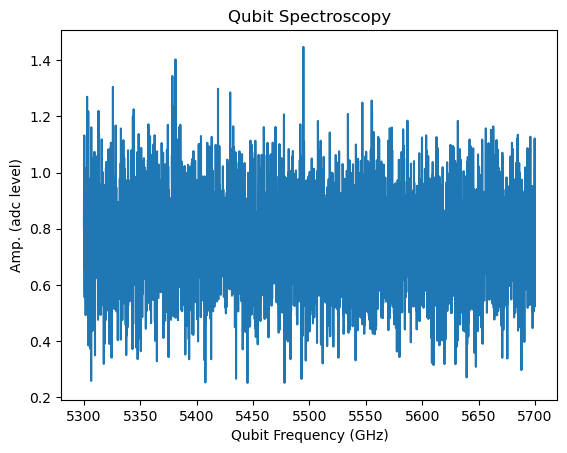

In [106]:
conf = QickConfig(params=params)
qspec=PulseProbeSpectroscopyProgram(*conf.config())
expt_pts, avgi, avgq = qspec.acquire(conf.soc,progress=True)

plt.subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (GHz)", ylabel="Amp. (adc level)")
plt.plot(expt_pts, avgi[0][0])
plt.show()

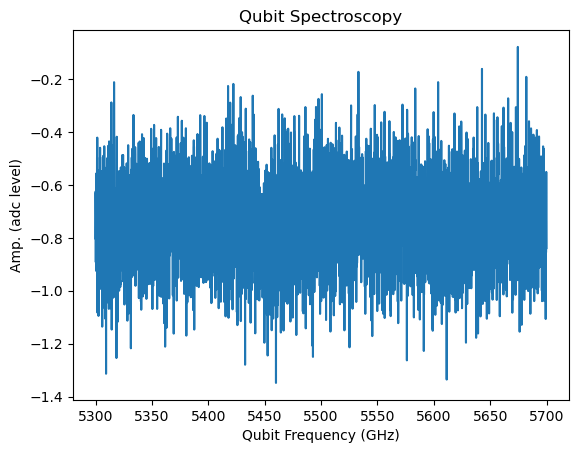

In [107]:
plt.subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (GHz)", ylabel="Amp. (adc level)")
plt.plot(expt_pts, avgq[0][0],)
plt.show()

## Power Rabi

In [118]:
class AmplitudeRabiProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")   # get gain register for qubit_ch    
        
        self.declare_gen(ch=cfg["read_gen_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["readout_freq"], gen_ch=cfg["read_gen_ch"])
        
        f_res=self.freq2reg(cfg["readout_freq"], gen_ch=cfg["read_gen_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["qubit_freq"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg["qubit_sigma"], length=cfg["qubit_sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=self.deg2reg(90, gen_ch=cfg["qubit_ch"]), gain=cfg["start"], waveform="qubit")
        self.set_pulse_registers(ch=cfg["read_gen_ch"], style="const", freq=f_res, phase=0, gain=cfg["readout_gain"], 
                                 length=cfg["readout_length"])
        
        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["read_gen_ch"], 
             adcs=[0],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
    
    def update(self):
        self.mathi(self.q_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update gain of the Gaussian pi pulse

In [139]:
conf = QickConfig(params=params)
rabi=AmplitudeRabiProgram(*conf.config())
x_pts, avgi, avgq  = rabi.acquire(conf.soc, progress=True)

Generating soccfg


  0%|          | 0/1500000 [00:00<?, ?it/s]

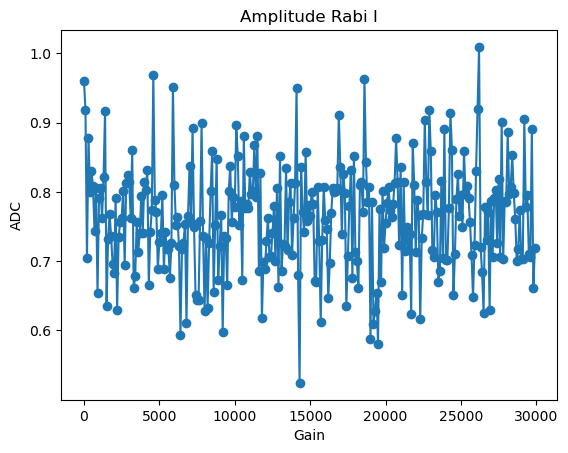

In [140]:
subplot(111, title= f"Amplitude Rabi I", xlabel="Gain", ylabel="ADC" )
plot(x_pts,avgi[0][0],'o-')

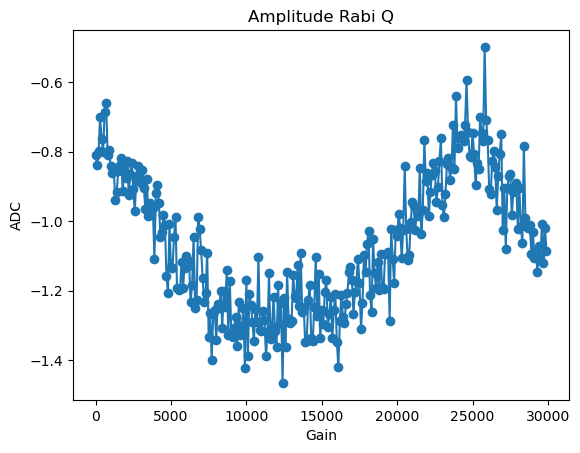

In [141]:
subplot(111, title= f"Amplitude Rabi Q", xlabel="Gain", ylabel="ADC" )
plot(x_pts,avgq[0][0],'o-')

In [149]:
class T1Program(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_wait = 3
        self.regwi(self.q_rp, self.r_wait, cfg["start"])

        self.declare_gen(ch=cfg["read_gen_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
         #configure the readout lengths and downconversion frequencies
        self.declare_readout(ch=cfg["read_ch"], length=cfg["readout_length"],
                                freq=cfg["readout_freq"], gen_ch=cfg["read_gen_ch"])
        
        f_res=self.freq2reg(cfg["readout_freq"], gen_ch=cfg["read_gen_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["qubit_freq"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg["qubit_sigma"], length=cfg["qubit_sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["qubit_gain"], 
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["read_gen_ch"], style="const", freq=f_res, phase=0, gain=cfg["readout_gain"], 
                                 length=cfg["readout_length"])

        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["read_gen_ch"], 
             adcs=[0],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
    
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index

In [154]:
conf = QickConfig(params=params)
t1p=T1Program(*conf.config())
x_pts, avgi, avgq = t1p.acquire(conf.soc, progress=True)


Generating soccfg


  0%|          | 0/5000 [00:00<?, ?it/s]

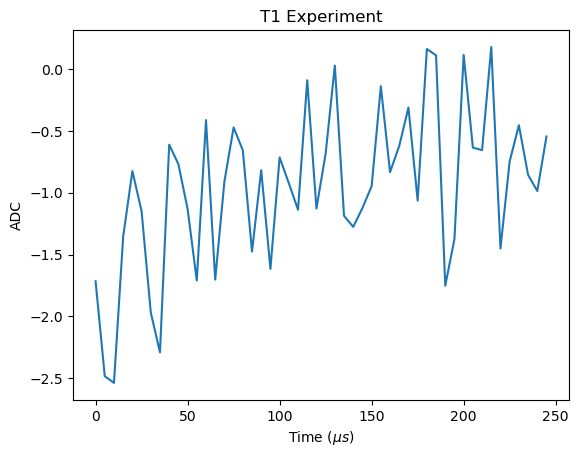

In [157]:

subplot(111, title="T1 Experiment", xlabel=f"Time ($\mu s$)", ylabel="ADC")
plot(x_pts, avgq[0][0],'')

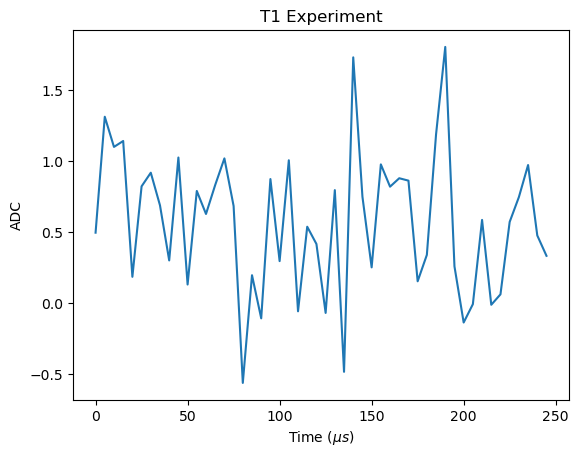

In [158]:
subplot(111, title="T1 Experiment", xlabel=f"Time ($\mu s$)", ylabel="ADC")
plot(x_pts, avgi[0][0],'')